In [4]:
#Prepare the timing parameters.

t_r = 2.4
slice_time_ref = 0.5
#Prepare the data. First, the volume-based fMRI data.

from nilearn.datasets import fetch_localizer_first_level
data = fetch_localizer_first_level()
fmri_img = data.epi_img
#Second, the experimental paradigm.

events_file = data.events
import pandas as pd
events = pd.read_table(events_file)

In [5]:
events

,Unnamed: 0,Unnamed: 0.1,trial_type,onset,duration
0,0,0,visual_computation,0.000000,1.0
1,1,1,visual_computation,2.400000,1.0
2,2,2,horizontal_checkerboard,8.700000,1.0
3,3,3,audio_right_hand_button_press,11.400000,1.0
4,4,4,sentence_listening,15.000000,1.0
...,...,...,...,...,...
75,75,75,sentence_listening,284.399994,1.0
76,76,76,sentence_reading,288.000000,1.0
77,77,77,visual_right_hand_button_press,291.000000,1.0
78,78,78,sentence_listening,293.399994,1.0


In [6]:
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage()
#The projection function simply takes the fMRI data and the mesh. Note that those correspond spatially, are they are both in MNI space.

from nilearn import surface
texture = surface.vol_to_surf(fmri_img, fsaverage.pial_right)

In [7]:
import numpy as np

n_scans = texture.shape[1]
frame_times = t_r * (np.arange(n_scans) + .5)
#Create the design matrix.

#We specify an hrf model containing the Glover model and its time derivative The drift model is implicitly a cosine basis with a period cutoff at 128s.

from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times,
                                               events=events,
                                               hrf_model='glover + derivative',
                                               drift_model=None
                                               )

/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


<AxesSubplot:label='conditions', ylabel='scan number'>

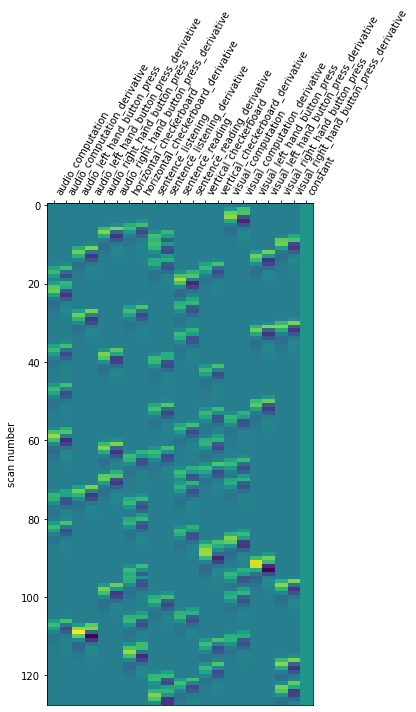

In [8]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

In [9]:
from nilearn.glm.first_level import run_glm
labels, estimates = run_glm(texture.T, design_matrix.values)


In [10]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrast_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [11]:
#At first, we create basic contrasts.

basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
#Next, we add some intermediate contrasts and one contrast adding all conditions with some auditory parts.

basic_contrasts['audio'] = (
    basic_contrasts['audio_left_hand_button_press']
    + basic_contrasts['audio_right_hand_button_press']
    + basic_contrasts['audio_computation']
    + basic_contrasts['sentence_listening'])

# one contrast adding all conditions involving instructions reading
basic_contrasts['visual'] = (
    basic_contrasts['visual_left_hand_button_press']
    + basic_contrasts['visual_right_hand_button_press']
    + basic_contrasts['visual_computation']
    + basic_contrasts['sentence_reading'])

# one contrast adding all conditions involving computation
basic_contrasts['computation'] = (basic_contrasts['visual_computation']
                                  + basic_contrasts['audio_computation'])

# one contrast adding all conditions involving sentences
basic_contrasts['sentences'] = (basic_contrasts['sentence_listening']
                                + basic_contrasts['sentence_reading'])

In [12]:
basic_contrasts['sentences']

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [13]:
texture.shape

(10242, 128)

In [14]:
contrasts = {
    'left - right button press': (
        basic_contrasts['audio_left_hand_button_press']
        - basic_contrasts['audio_right_hand_button_press']
        + basic_contrasts['visual_left_hand_button_press']
        - basic_contrasts['visual_right_hand_button_press']
    ),
    'audio - visual': basic_contrasts['audio'] - basic_contrasts['visual'],
    'computation - sentences': (basic_contrasts['computation'] -
                                basic_contrasts['sentences']
    )
}

  Contrast  1 out of 3: left - right button press, right hemisphere
  Contrast  2 out of 3: audio - visual, right hemisphere
  Contrast  3 out of 3: computation - sentences, right hemisphere


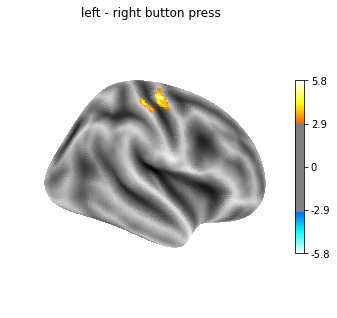

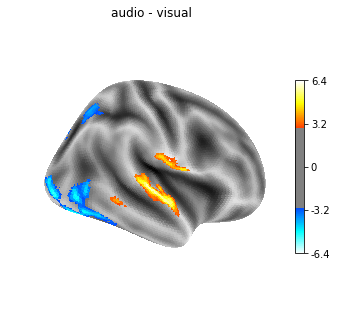

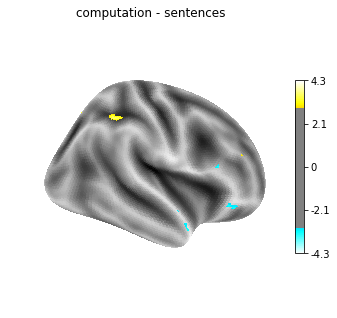

In [16]:
#Let’s estimate the contrasts by iterating over them.

from nilearn.glm.contrasts import compute_contrast
from nilearn import plotting

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, right hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    plotting.plot_surf_stat_map(
        fsaverage.infl_right, z_score, hemi='right',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_right)

In [30]:
contrast = compute_contrast(labels, estimates, np.array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -,  0., -1.,  0.,  0.,
        0.,  0,  0.,  0.,  0.,  0.,  0.,  0.]),
                                contrast_type='t')